In [33]:
import ete3
import treeCl
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from Bio import AlignIO
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS
import re

%cd /work/site_rate/tree_cloud

/work/site_rate/tree_cloud


In [5]:
def prepare_data(category):
    aln = AlignIO.read('%s.aln' % category, 'fasta')
    for num, line in enumerate(open('%s.boottrees' % category, 'r'), 1):
        AlignIO.write(aln[:, :10], 'alignments/%s_%i.fas' %(category, num), format='fasta')
        
        out = open('trees/%s_%i.nwk' % (category, num), 'w')
        out.write(line)
        out.close()

for category in range(1,13):
    prepare_data(str(category))

prepare_data('whole_alignment')

In [7]:
tree_data = treeCl.Collection(input_dir='alignments', file_format='fasta', trees_dir='trees')

Loading files: 1282 of 1282 |#############| Elapsed Time: 0:00:09 Time: 0:00:09
Loading trees: 100% |#####################| Elapsed Time: 0:00:02 Time: 0:00:02


In [ ]:
processes = treeCl.parutils.ProcesspoolJobHandler(18)  # with pure python code, it is better to use processpools to parallelise for speed
distance_matrix = tree_data.get_inter_tree_distances('rf',
                                                     jobhandler=processes,
                                                     batchsize=100)  # jobs are done in batches to reduce overhead

df = pd.DataFrame(data=distance_matrix.values,
                  index=distance_matrix.get_names(),
                  columns=distance_matrix.get_names())

df.to_csv('rf_distances.csv')

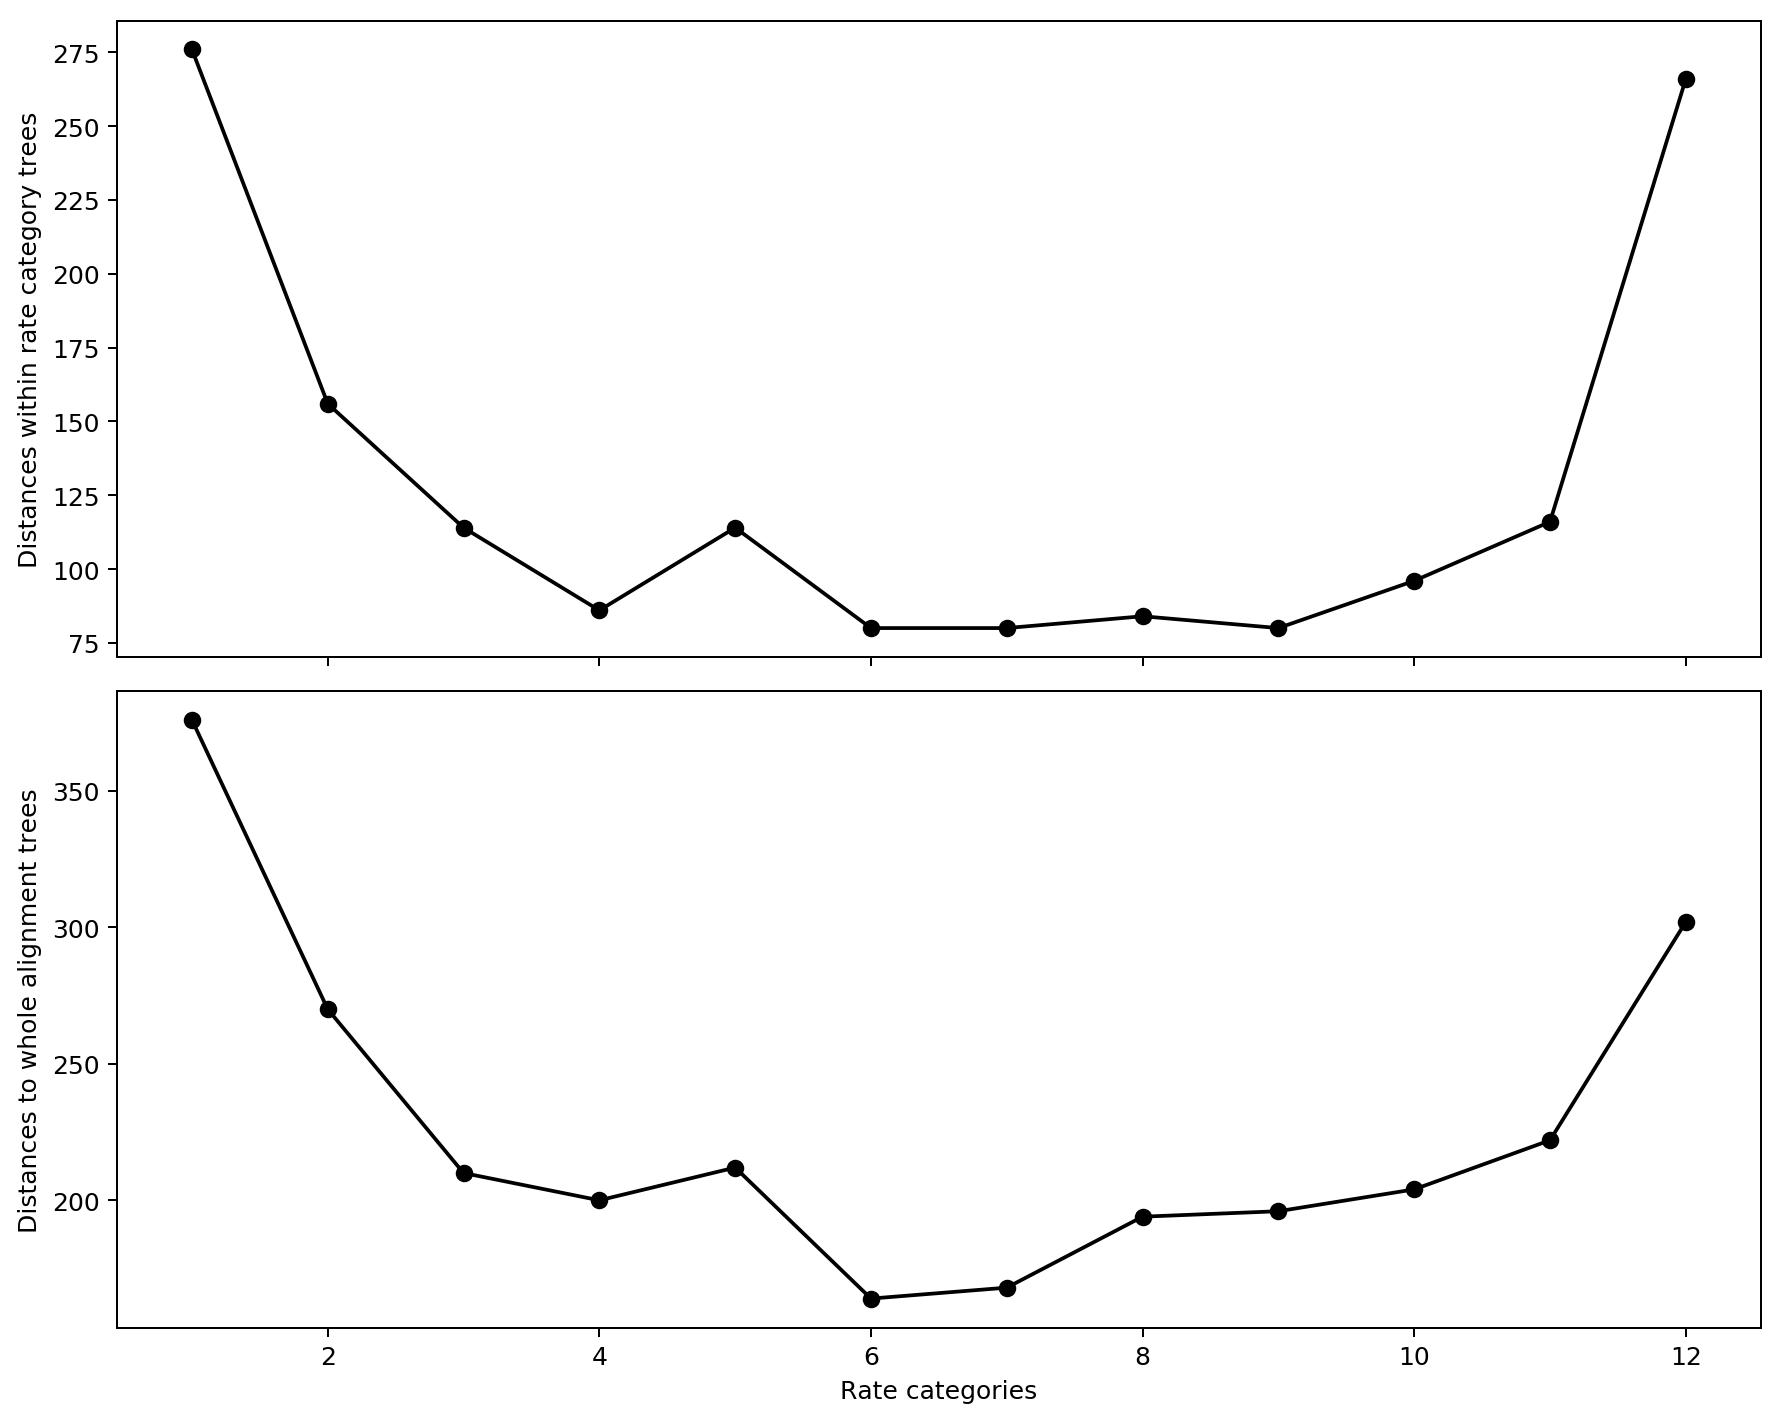

In [100]:
intra_distances = []
for category in range(1,13):
    category_indexes = df.index[df.index.str.startswith('%i_' % category)]
    tmp_df = df.reindex(index=category_indexes, columns=category_indexes, copy=True)
    intra_distances.append(np.median(squareform(tmp_df.values)))

fig, axs = plt.subplots(nrows=2, sharex=True, dpi=180, figsize=(10,8))
axs[0].plot(range(1,13), intra_distances, 'ko-')
axs[0].set_ylabel('Distances within rate category trees')

whole_alignment_indexes = df.index[df.index.str.startswith('whole')]
distances_to_whole_aln = []
for category in range(1,13):
    category_indexes = df.index[df.index.str.startswith('%i_' % category)]
    tmp_df = df.reindex(index=category_indexes, columns=whole_alignment_indexes, copy=True)
    distances_to_whole_aln.append(np.median(tmp_df.values.flatten()))

axs[1].plot(range(1,13), distances_to_whole_aln, 'ko-')
axs[1].set_ylabel('Distances to whole alignment trees')
axs[1].set_xlabel('Rate categories')
fig.tight_layout()

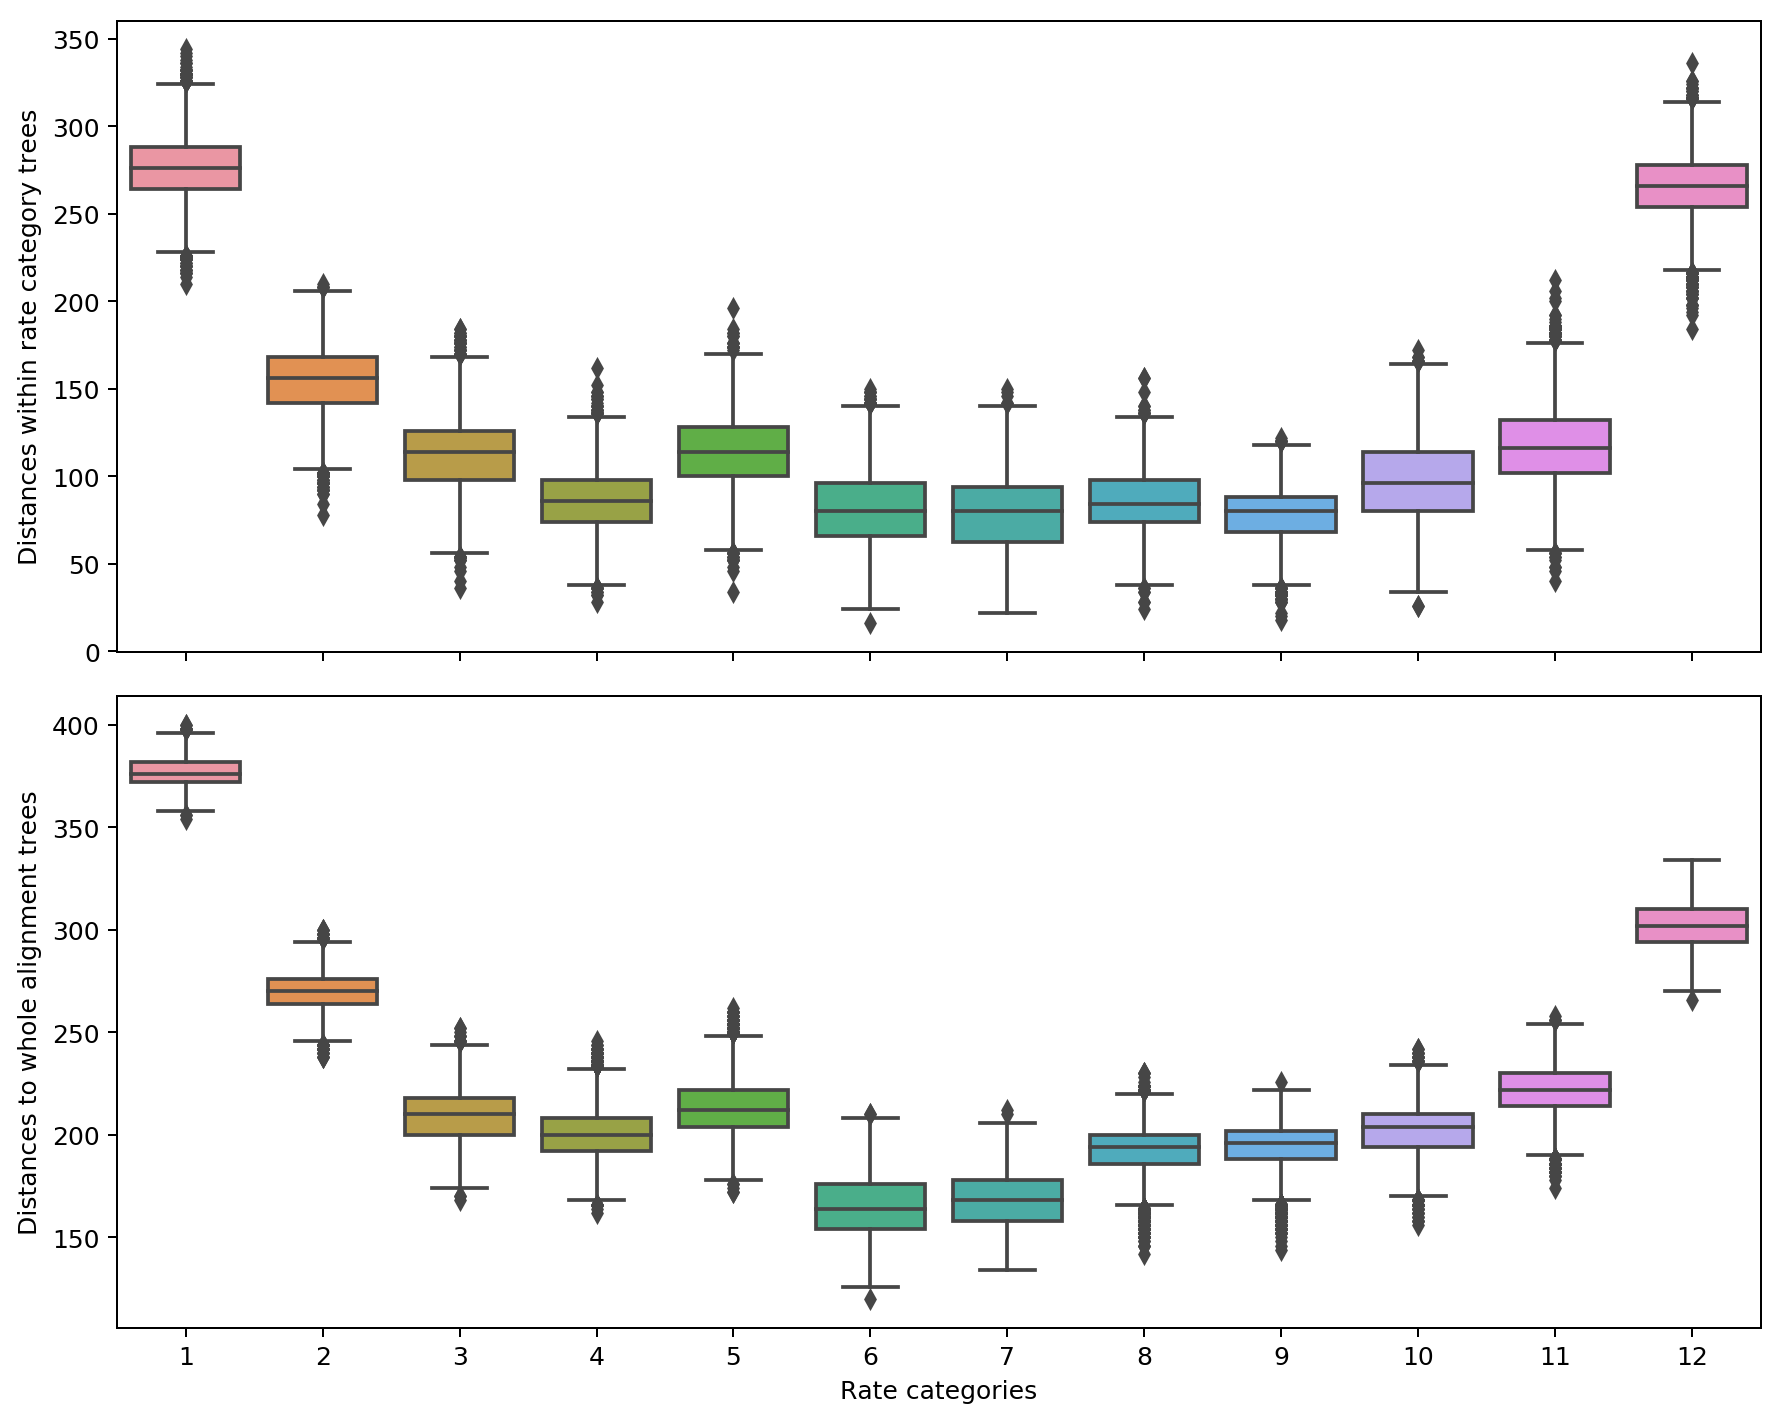

In [99]:
intra_distances = []
for category in range(1,13):
    category_indexes = df.index[df.index.str.startswith('%i_' % category)]
    tmp_df = df.reindex(index=category_indexes, columns=category_indexes, copy=True)
    intra_distances.append(squareform(tmp_df.values))

fig, axs = plt.subplots(nrows=2, sharex=True, dpi=180, figsize=(10,8))
sns.boxplot(x=range(1,13), y=intra_distances, ax=axs[0])
axs[0].set_ylabel('Distances within rate category trees')

whole_alignment_indexes = df.index[df.index.str.startswith('whole')]
distances_to_whole_aln = []
for category in range(1,13):
    category_indexes = df.index[df.index.str.startswith('%i_' % category)]
    tmp_df = df.reindex(index=category_indexes, columns=whole_alignment_indexes, copy=True)
    distances_to_whole_aln.append(tmp_df.values.flatten())
    
sns.boxplot(x=range(1,13), y=distances_to_whole_aln, ax=axs[1])
axs[1].set_ylabel('Distances to whole alignment trees')
axs[1].set_xlabel('Rate categories')

fig.tight_layout()

In [43]:
cmap = plt.get_cmap('rainbow')
color_range = {str(index):'#%02x%02x%02x' % cmap(value, bytes=True)[:3] for index, value in enumerate(np.linspace(0, 1, 12),1)}
colors = {index:color_range[index.split('_')[0]] for index in df.index if not index.startswith('whole')}

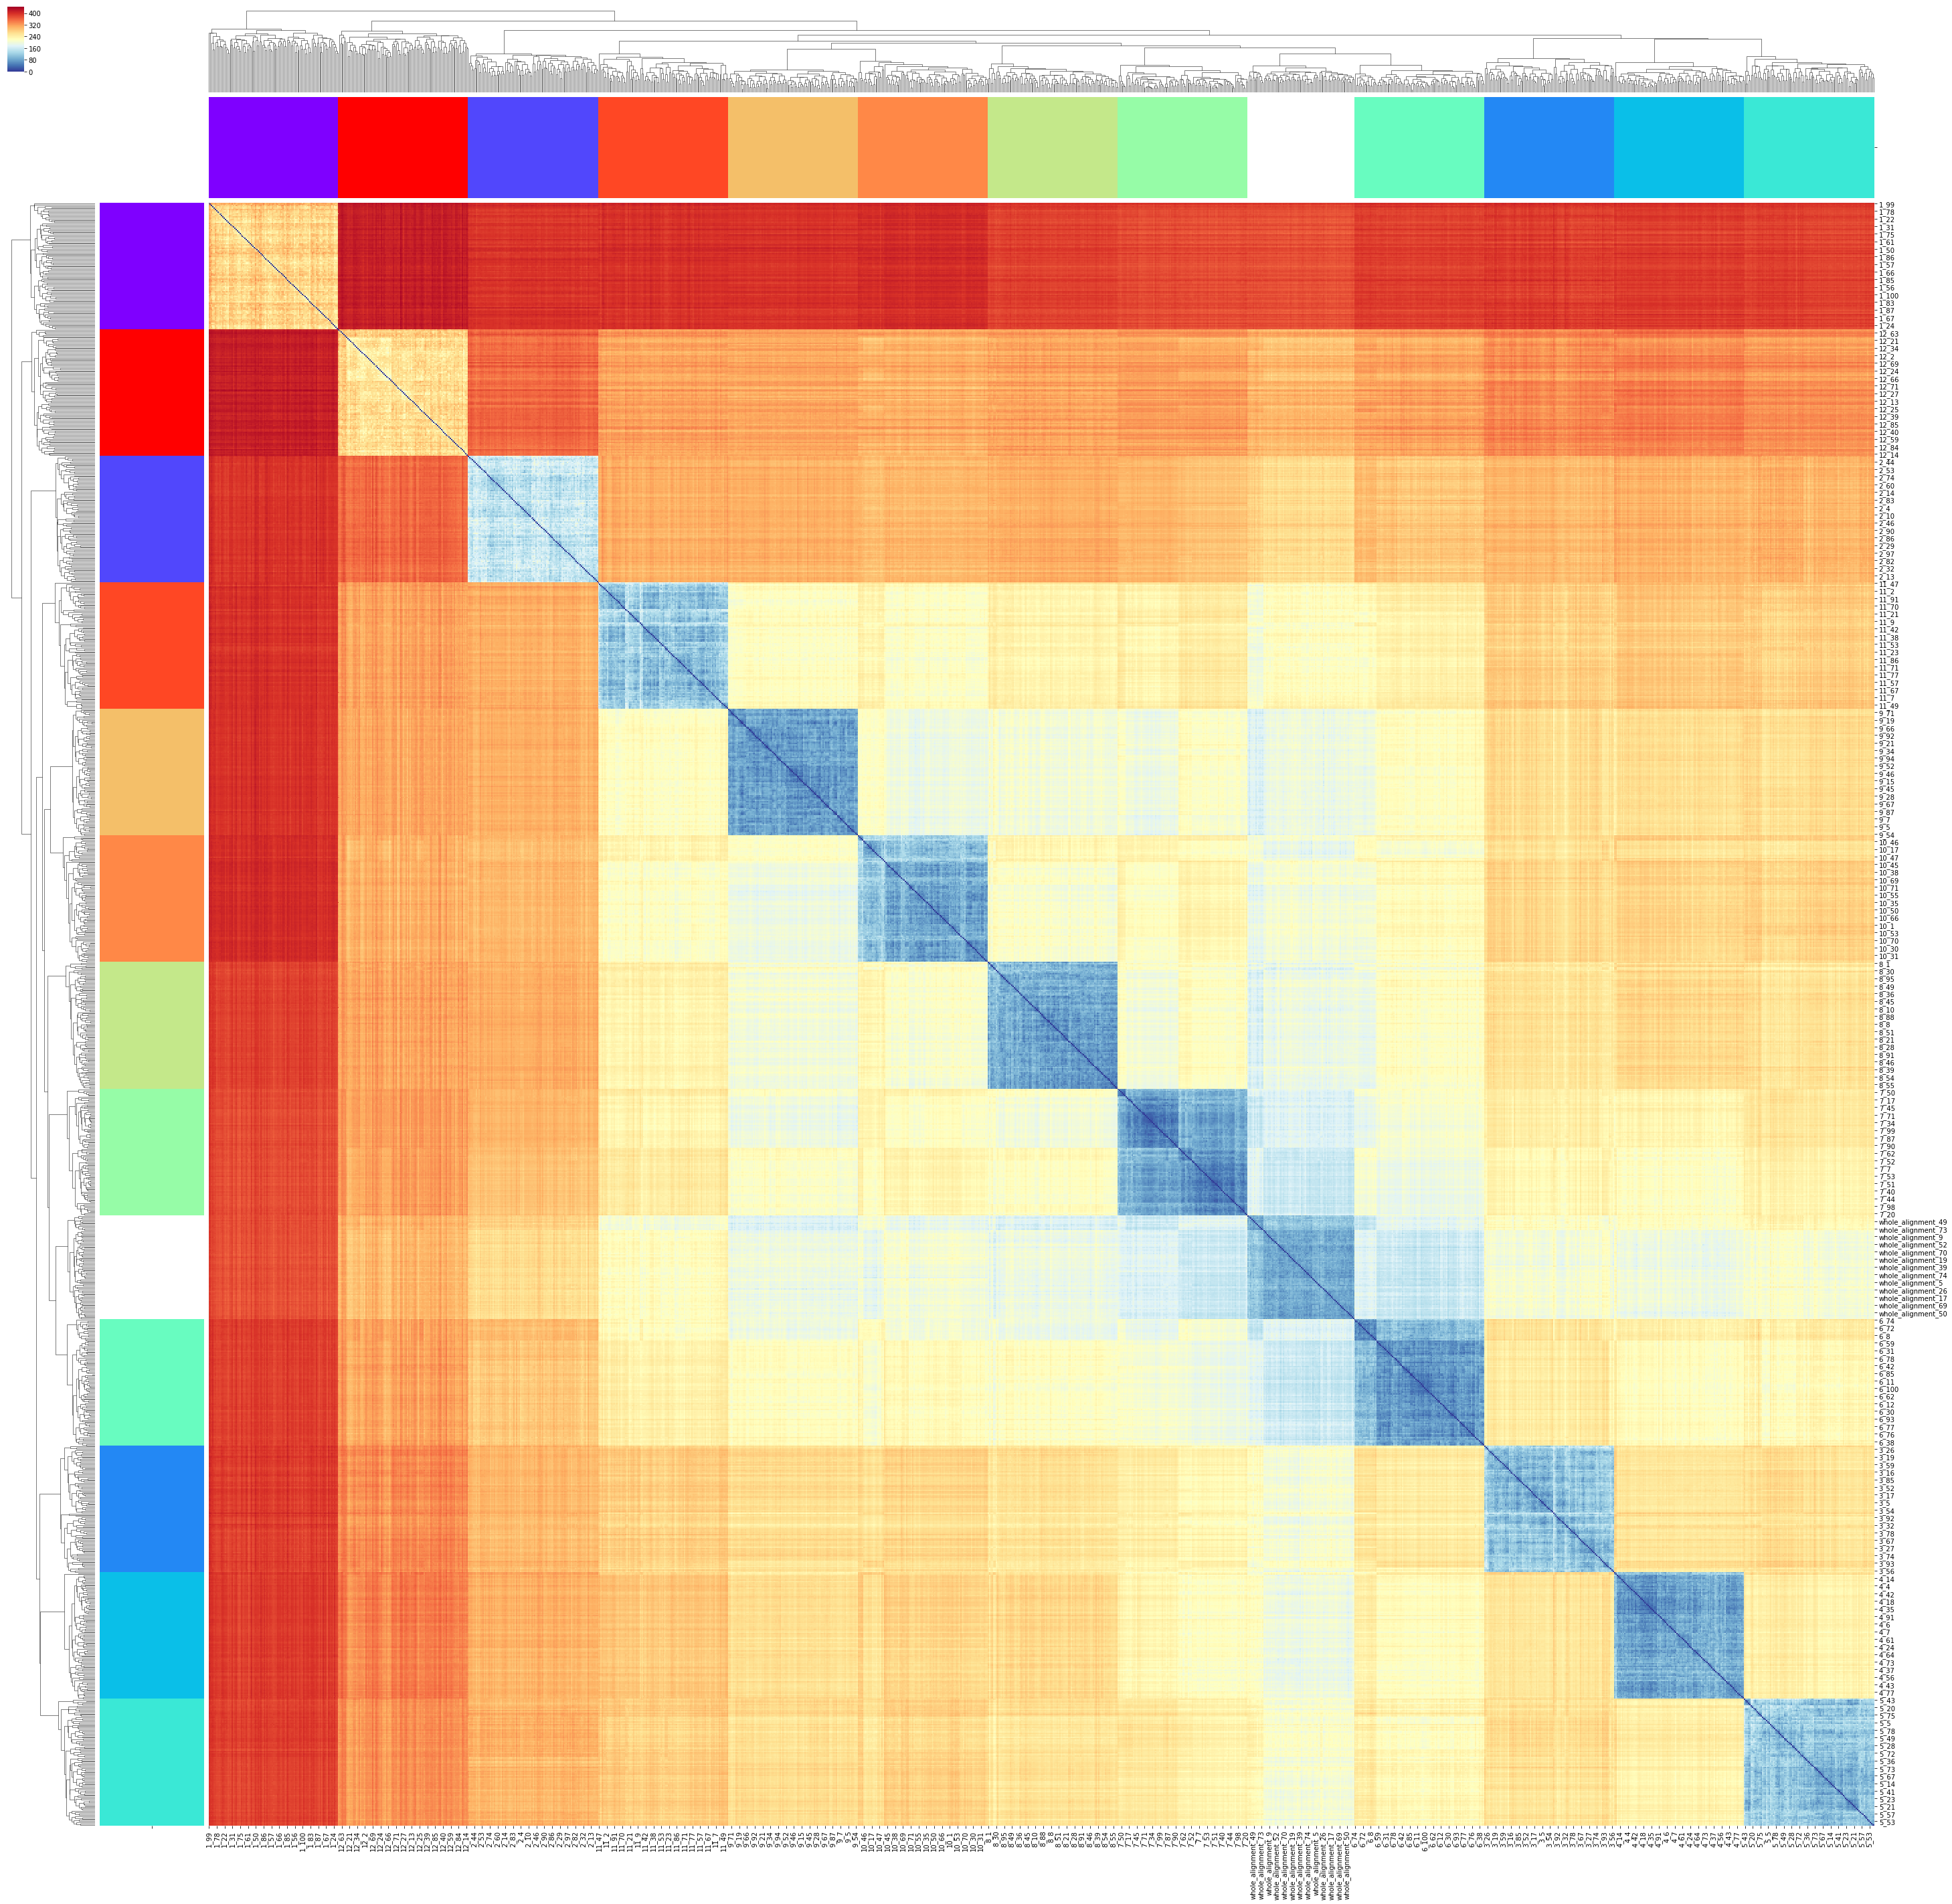

In [51]:
row_linkage = linkage(y=squareform(df.values), method='complete')
sns.clustermap(df, row_linkage=row_linkage, col_linkage=row_linkage,
               figsize=(50,50), cmap='RdYlBu_r', row_colors=pd.Series(colors), col_colors=pd.Series(colors))

In [14]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
coords    = embedding.fit_transform(df.values)
coords_df = pd.DataFrame(data=coords, columns='x y'.split(), index=df.index)
        
coords_df['gene_type'] = [re.sub('_\d+$', '', index, flags=re.M) for index in coords_df.index]

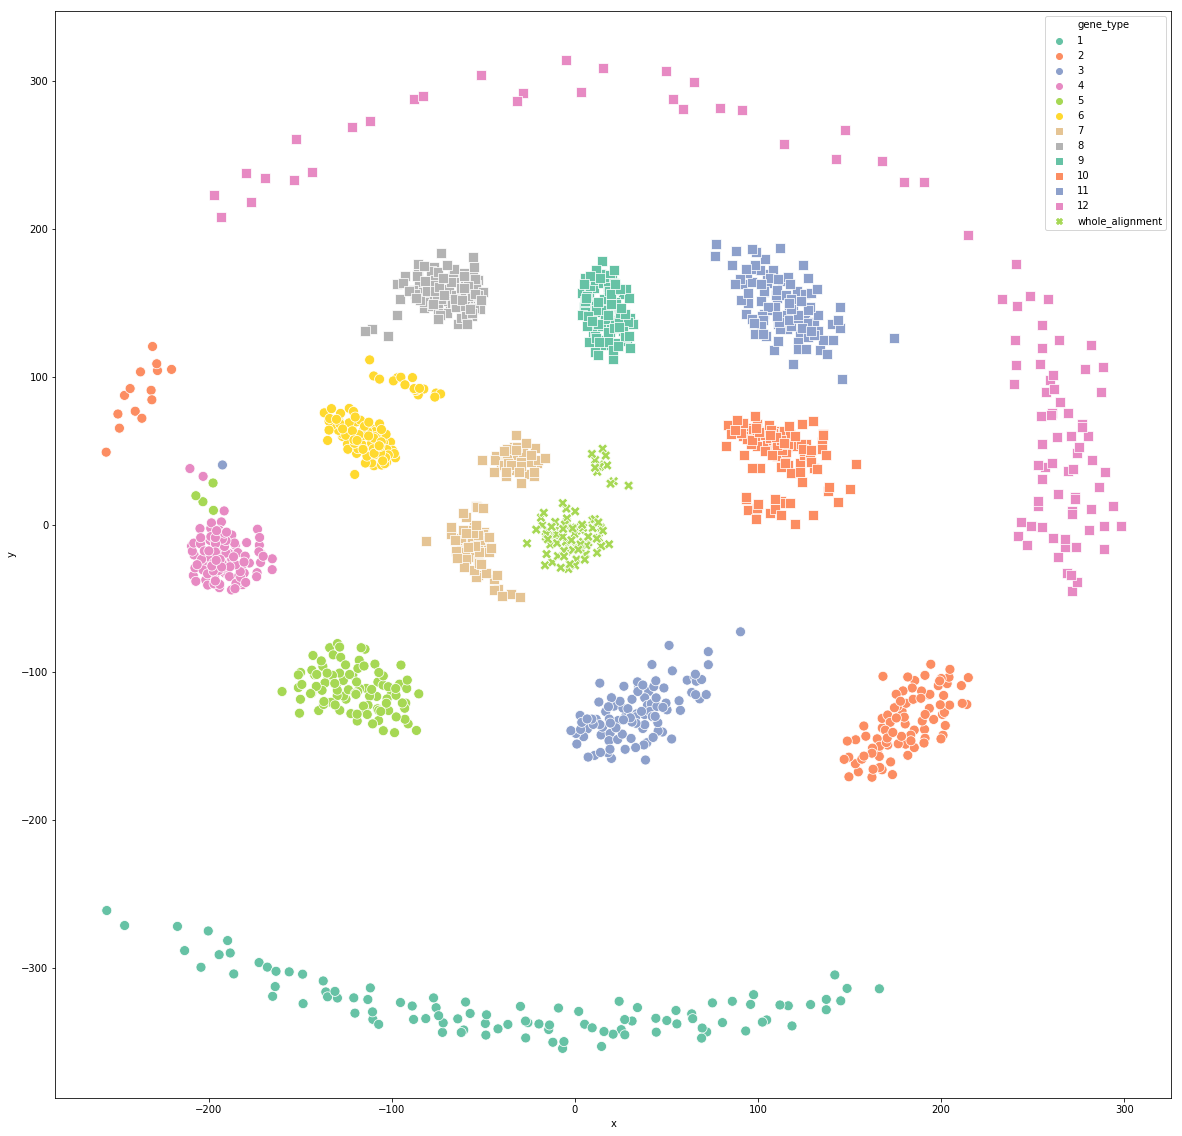

In [50]:
markers = {str(num):'o' for num in range(1,7)}
markers.update({str(num):'s' for num in range(7,13)})
markers['whole_alignment'] = 'X'
fig, ax = plt.subplots(figsize=(20,20))
sns.scatterplot(x='x', y='y', hue='gene_type',
                style='gene_type', data=coords_df,
                ax=ax, s=100, palette="Set2",
                markers=markers, alpha=1)